# FET445 – Veri Madenciliği  
## Cüneyd Melledham – Alternatif Özellik Seçimi ve Boyut İndirgeme

Bu notebook, **Depression Dataset** üzerinde çalışarak:

- Ortak veri keşfi (EDA) ve ön işleme adımlarını,
- Cüneyd'in sorumlu olduğu **alternatif özellik seçimi** ve **boyut indirgeme** tekniklerini,
- Ve bunların farklı **temel (base) modeller üzerindeki etkisini** göstermektedir.

Hedef değişken (**target**): `History of Mental Illness`  
Görev türü: **İkili sınıflandırma (binary classification)**.


## 1. Problem Tanımı

Bu projede amaç, bireylerin yaşam tarzı, demografik özellikleri ve sağlık durumları gibi
değişkenleri kullanarak, geçmişte herhangi bir psikolojik rahatsızlık yaşayıp yaşamadıklarını
tahmin etmektir.

Bu notebook'ta **Cüneyd'in katkısı**:

- Ortak veri ön işleme pipeline'ının kullanılması,
- Farklı **özellik seçimi** tekniklerinin denenmesi:
  - `SelectKBest(mutual_info_classif)` ile farklı `k` değerleri,
- Sadece **PCA** kullanarak boyut indirgeme ve bunu baz modellerle kıyaslama,
- İki temel modelin kullanılması:
  - Lojistik Regresyon (`LogisticRegression`)
  - Karar Ağacı (`DecisionTreeClassifier`),
- Ve tüm aşamalar için **performans karşılaştırması** yapılmasıdır.


## 2. Kurulum ve Gerekli Kütüphaneler

Bu bölümde veri işleme, modelleme ve değerlendirme için gerekli Python kütüphaneleri yüklenmektedir.


In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)


## 3. Veri Setini Yükleme

Bu projede Kaggle üzerinde yer alan **Depression Dataset** kullanılmaktadır.  
Lütfen aynı klasörde veri dosyasının adını uygun şekilde ayarlayın.

- Önerilen dosya adı: `depression_data.csv`
- Hedef sütun: `History of Mental Illness`


In [3]:
# Dosya yolu ve hedef sütun adı
CSV_PATH = "depression_data.csv"  # Gerekirse burayı kendi dosya adınla değiştir
TARGET_COL = "History of Mental Illness"  # Kaggle veri setindeki orijinal sütun adı

# Veriyi oku
df = pd.read_csv(CSV_PATH)

# Hedef sütunu 0/1'e çeviriyoruz: No -> 0, Yes -> 1
df[TARGET_COL] = df[TARGET_COL].map({"No": 0, "Yes": 1})

print("Veri şekli (satır, sütun):", df.shape)
df.head()


Veri şekli (satır, sütun): (413768, 16)


,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,1,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,1,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,0,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,0,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,1,No,Yes,Yes


## 4. Veri Setinin Genel Özeti

Bu bölümde veri setinin temel yapısı incelenmektedir:
- Sütun isimleri ve veri tipleri
- Sayısal ve kategorik sütunların ayrımı


In [13]:
# Sütun bilgileri
print("Sütun tipleri:\n")
print(df.dtypes)

print("\nİlk 5 gözlem:")
df.head()


Sütun tipleri:

Name                             object
Age                               int64
Marital Status                   object
Education Level                  object
Number of Children                int64
Smoking Status                   object
Physical Activity Level          object
Employment Status                object
Income                          float64
Alcohol Consumption              object
Dietary Habits                   object
Sleep Patterns                   object
History of Mental Illness         int64
History of Substance Abuse       object
Family History of Depression     object
Chronic Medical Conditions       object
dtype: object

İlk 5 gözlem:


,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,1,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,1,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,0,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,0,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,1,No,Yes,Yes


## 5. Eksik Değer Analizi ve Hedef Değişkenin Dağılımı

Modelleme öncesi:
- Hangi sütunlarda eksik veri var?
- Hedef sınıflar dengeli mi, dengesiz mi?


Eksik değer sayıları:

Name                            0
Age                             0
Marital Status                  0
Education Level                 0
Number of Children              0
Smoking Status                  0
Physical Activity Level         0
Employment Status               0
Income                          0
Alcohol Consumption             0
Dietary Habits                  0
Sleep Patterns                  0
History of Mental Illness       0
History of Substance Abuse      0
Family History of Depression    0
Chronic Medical Conditions      0
dtype: int64

Hedef değişken dağılımı (adet):
History of Mental Illness
0    287943
1    125825
Name: count, dtype: int64

Hedef değişken dağılımı (oran):
History of Mental Illness
0    0.695904
1    0.304096
Name: proportion, dtype: float64


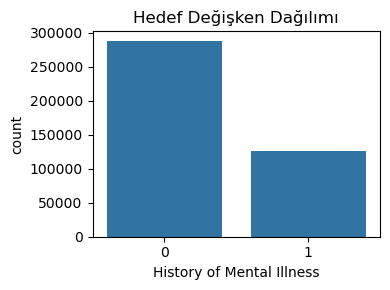

In [5]:
# Eksik değer sayıları
print("Eksik değer sayıları:\n")
print(df.isna().sum())

# Hedef değişken dağılımı
print("\nHedef değişken dağılımı (adet):")
print(df[TARGET_COL].value_counts())

print("\nHedef değişken dağılımı (oran):")
print(df[TARGET_COL].value_counts(normalize=True))

# Hedef dağılımı görselleştirme
plt.figure(figsize=(4,3))
sns.countplot(x=TARGET_COL, data=df)
plt.title("Hedef Değişken Dağılımı")
plt.tight_layout()
plt.show()


## 6. Özellik Türlerini Belirleme (Sayısal vs. Kategorik)

Makine öğrenmesi modelleri için sayısal ve kategorik sütunlara farklı ön işleme
adımları uygulanacaktır.

- Sayısal sütunlar: Ölçeklendirme (scaling)
- Kategorik sütunlar: One-Hot Encoding


In [7]:
# Özellik ve hedef ayrımı
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Sayısal ve kategorik sütunları otomatik bul
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("Sayısal sütunlar:", num_cols)
print("Kategorik sütunlar:", cat_cols)


Sayısal sütunlar: ['Age', 'Number of Children', 'Income']
Kategorik sütunlar: ['Name', 'Marital Status', 'Education Level', 'Smoking Status', 'Physical Activity Level', 'Employment Status', 'Alcohol Consumption', 'Dietary Habits', 'Sleep Patterns', 'History of Substance Abuse', 'Family History of Depression', 'Chronic Medical Conditions']


## 7. Ortak Ön İşleme Adımları (Preprocessing Pipeline)

Bu pipeline **tüm modeller** için ortaktır ve şu adımlardan oluşur:

- Sayısal sütunlar için:
  - Eksik değer doldurma (median)
  - Min-Max ölçeklendirme (0–1 aralığı)
- Kategorik sütunlar için:
  - Eksik değer doldurma (en sık görülen)
  - One-Hot Encoding


In [15]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


## 8. Eğitim ve Test Kümesine Ayırma

Veri seti eğitim (train) ve test olarak ikiye ayrılacaktır.

- Test oranı: %20  
- Stratify: Hedef değişkenin sınıf dağılımını korumak için kullanılır.


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Eğitim kümesi boyutu:", X_train.shape)
print("Test kümesi boyutu:", X_test.shape)

print("Unique in y_train:", np.unique(y_train))
print("Unique in y_test:", np.unique(y_test))


Eğitim kümesi boyutu: (331014, 15)
Test kümesi boyutu: (82754, 15)
Unique in y_train: [0 1]
Unique in y_test: [0 1]


## 9. Değerlendirme Fonksiyonu

Tüm modeller için aynı değerlendirme fonksiyonu kullanılacaktır.

Hesaplanan metrikler:
- Doğruluk (Accuracy)
- F1 skoru
- ROC AUC (model olasılık tahmini veriyorsa)
- Sınıflandırma raporu ve karışıklık matrisi


In [19]:
def evaluate_model(name, pipeline, X_train, y_train, X_test, y_test):
    # Verilen pipeline'i egitir ve temel siniflandirma metriklerini hesaplar.
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Bazı modeller predict_proba desteklemeyebilir
    auc = None
    if hasattr(pipeline, "predict_proba"):
        try:
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_proba)
        except Exception:
            auc = None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"=== {name} ===")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    if auc is not None:
        print("ROC AUC:", auc)
    print("\nSınıflandırma Raporu:")
    print(classification_report(y_test, y_pred))

    # Karışıklık matrisi
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Tahmin")
    plt.ylabel("Gerçek")
    plt.tight_layout()
    plt.show()

    return {
        "name": name,
        "accuracy": acc,
        "f1": f1,
        "auc": auc
    }


## 10. Baz Modeller (Özellik Seçimi ve Boyut İndirgeme OLMADAN)

Bu bölümde ortak ön işleme adımlarını kullanarak, aşağıdaki iki temel model eğitilir:

- Lojistik Regresyon (`LogisticRegression`)
- Karar Ağacı (`DecisionTreeClassifier`)

Bu sonuçlar, daha sonra **özellik seçimi** ve **PCA ile boyut indirgeme** sonrası elde edilen performans
ile karşılaştırılacaktır.


=== Baz Model - Logistic Regression ===
Accuracy: 0.6843052903787128
F1 Score: 0.10306588388780169
ROC AUC: 0.5693149766577145

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.70      0.96      0.81     57589
           1       0.38      0.06      0.10     25165

    accuracy                           0.68     82754
   macro avg       0.54      0.51      0.46     82754
weighted avg       0.60      0.68      0.59     82754



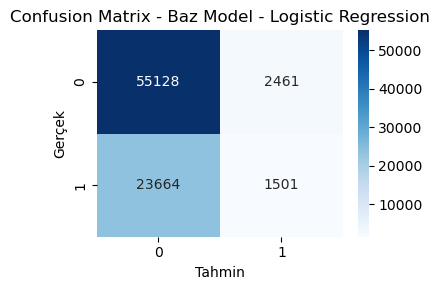

=== Baz Model - Decision Tree ===
Accuracy: 0.6955434178408294
F1 Score: 0.004504326524161366
ROC AUC: 0.5959517454815064

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     57589
           1       0.40      0.00      0.00     25165

    accuracy                           0.70     82754
   macro avg       0.55      0.50      0.41     82754
weighted avg       0.60      0.70      0.57     82754



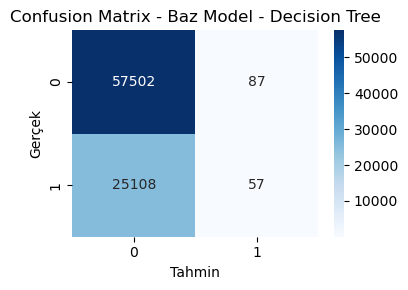

In [21]:
baseline_results = []

# 1) Lojistik Regresyon (baseline)
log_reg = LogisticRegression(max_iter=1000, solver="liblinear")

baseline_lr_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", log_reg)
])

res_baseline_lr = evaluate_model(
    "Baz Model - Logistic Regression",
    baseline_lr_pipeline,
    X_train, y_train,
    X_test, y_test
)
baseline_results.append(res_baseline_lr)

# 2) Karar Ağacı (baseline)
dt_clf = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_leaf=500)

baseline_dt_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", dt_clf)
])

res_baseline_dt = evaluate_model(
    "Baz Model - Decision Tree",
    baseline_dt_pipeline,
    X_train, y_train,
    X_test, y_test
)
baseline_results.append(res_baseline_dt)


## 11. Cüneyd – Özellik Seçimi (SelectKBest – mutual_info_classif, Farklı k Değerleri)

Bu bölümde Cüneyd'in sorumlu olduğu özellik seçimi tekniği uygulanmaktadır:

- **Yöntem:** `SelectKBest(score_func=mutual_info_classif)`
- Amaç: Hedef değişken ile ilişkisi en yüksek olan sütunları seçmek.
- İki farklı `k` değeri denenmektedir: `k=10` ve `k=30`.

Her birinde:
- Lojistik Regresyon
- Karar Ağacı

modelleri eğitilir ve sonuçlar baz modeller ile karşılaştırılır.


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


=== Cüneyt - LR + SelectKBest(MI), k=10 ===
Accuracy: 0.6959059380815429
F1 Score: 0.0
ROC AUC: 0.5914263449315575

Sınıflandırma Raporu:


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.70      1.00      0.82     57589
           1       0.00      0.00      0.00     25165

    accuracy                           0.70     82754
   macro avg       0.35      0.50      0.41     82754
weighted avg       0.48      0.70      0.57     82754



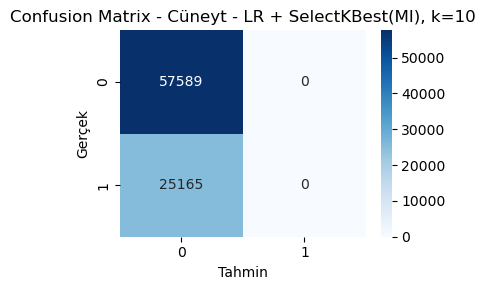

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


=== Cüneyt - DT + SelectKBest(MI), k=10 ===
Accuracy: 0.5829204630591874
F1 Score: 0.32507479614384327
ROC AUC: 0.5118047530277318

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.70      0.69      0.70     57589
           1       0.32      0.33      0.33     25165

    accuracy                           0.58     82754
   macro avg       0.51      0.51      0.51     82754
weighted avg       0.59      0.58      0.58     82754



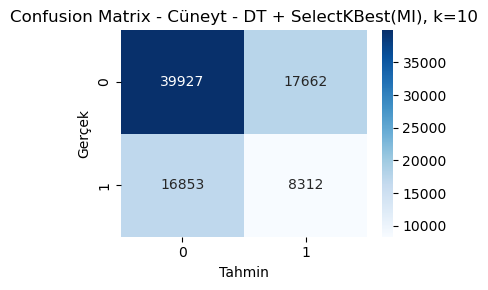

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


=== Cüneyt - LR + SelectKBest(MI), k=30 ===
Accuracy: 0.6956642579210672
F1 Score: 0.0014273819436184131
ROC AUC: 0.591398521136629

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82     57589
           1       0.32      0.00      0.00     25165

    accuracy                           0.70     82754
   macro avg       0.51      0.50      0.41     82754
weighted avg       0.58      0.70      0.57     82754



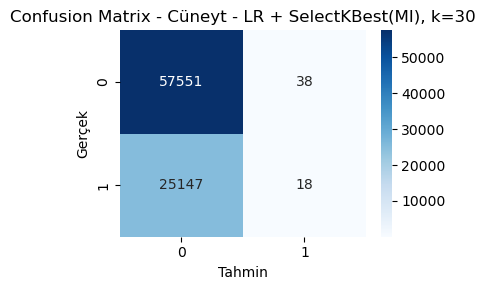

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


=== Cüneyt - DT + SelectKBest(MI), k=30 ===
Accuracy: 0.5818087343209996
F1 Score: 0.3287623407102818
ROC AUC: 0.512843100924856

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.70      0.69      0.70     57589
           1       0.32      0.34      0.33     25165

    accuracy                           0.58     82754
   macro avg       0.51      0.51      0.51     82754
weighted avg       0.59      0.58      0.58     82754



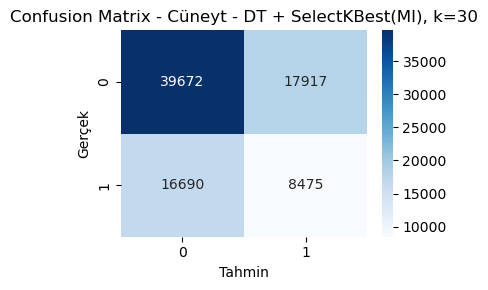


*** Bitti! Sonuçlar Hazır ***


In [23]:
# --- Cüneyt Feature Selection & Modeling (Fixed Version) ---

# 1) 
X_train_fs = X_train.sample(40000, random_state=42)
y_train_fs = y_train.loc[X_train_fs.index]

cy_results = []   # لحفظ النتائج

# ---------------------------
# (1) Logistic Regression + SelectKBest(k=10)
# ---------------------------
selector_10 = SelectKBest(score_func=mutual_info_classif, k=10)

lr_fs_k10 = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("fsel", selector_10),
    ("model", LogisticRegression(max_iter=1000, solver="liblinear")),
])

res_lr_k10 = evaluate_model(
    "Cüneyt - LR + SelectKBest(MI), k=10",
    lr_fs_k10,
    X_train_fs, y_train_fs,
    X_test, y_test
)
cy_results.append(res_lr_k10)

# ---------------------------
# (2) Decision Tree + SelectKBest(k=10)
# ---------------------------
selector_10_dt = SelectKBest(score_func=mutual_info_classif, k=10)

dt_fs_k10 = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("fsel", selector_10_dt),
    ("model", DecisionTreeClassifier(random_state=42)),
])

res_dt_k10 = evaluate_model(
    "Cüneyt - DT + SelectKBest(MI), k=10",
    dt_fs_k10,
    X_train_fs, y_train_fs,
    X_test, y_test
)
cy_results.append(res_dt_k10)

# ---------------------------
# (3) Logistic Regression + SelectKBest(k=30)
# ---------------------------
selector_30 = SelectKBest(score_func=mutual_info_classif, k=30)

lr_fs_k30 = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("fsel", selector_30),
    ("model", LogisticRegression(max_iter=1000, solver="liblinear")),
])

res_lr_k30 = evaluate_model(
    "Cüneyt - LR + SelectKBest(MI), k=30",
    lr_fs_k30,
    X_train_fs, y_train_fs,
    X_test, y_test
)
cy_results.append(res_lr_k30)

# ---------------------------
# (4) Decision Tree + SelectKBest(k=30)
# ---------------------------
selector_30_dt = SelectKBest(score_func=mutual_info_classif, k=30)

dt_fs_k30 = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("fsel", selector_30_dt),
    ("model", DecisionTreeClassifier(random_state=42)),
])

res_dt_k30 = evaluate_model(
    "Cüneyt - DT + SelectKBest(MI), k=30",
    dt_fs_k30,
    X_train_fs, y_train_fs,
    X_test, y_test
)
cy_results.append(res_dt_k30)

print("\n*** Bitti! Sonuçlar Hazır ***")

## 12. Cüneyd – Boyut İndirgeme (Sadece PCA, Farklı Bileşen Sayıları)

Bu bölümde, özellik seçimi yapılmadan sadece **PCA** uygulanmaktadır.

Amaç:
- One-Hot sonrası yüksek boyutlu uzayı PCA ile küçültmek,
- Farklı bileşen sayılarının (örneğin 5 ve 15) modeller üzerindeki etkisini görmek.

Her bir PCA ayarında:
- Lojistik Regresyon
- Karar Ağacı

tekrar eğitilir.


In [33]:
# 12. Cüneyed – Boyut İndirgeme (Sadece PCA, Farklı Bileşen Sayıları)

# نأخذ عينة من بيانات التدريب لتخفيف الوقت (40 ألف صف)
X_train_pca = X_train.sample(40000, random_state=42)
y_train_pca = y_train.loc[X_train_pca.index]

# محول بسيط يحول المصفوفة من sparse إلى dense
to_dense = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)

for n_comp in [5, 15]:
    # 1) LR + PCA
    lr_pca_pipeline = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("to_dense", to_dense),                     # هنا التحويل إلى dense
        ("pca", PCA(n_components=n_comp)),
        ("model", LogisticRegression(max_iter=1000, solver="liblinear"))
    ])

    res_lr_pca = evaluate_model(
        f"Cüneyt - LR + PCA(n_components={n_comp})",
        lr_pca_pipeline,
        X_train_pca, y_train_pca,
        X_test, y_test
    )
    cy_results.append(res_lr_pca)

    # 2) DT + PCA
    dt_pca_pipeline = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("to_dense", to_dense),                     # نفس الشيء
        ("pca", PCA(n_components=n_comp)),
        ("model", DecisionTreeClassifier(random_state=42))
    ])

    res_dt_pca = evaluate_model(
        f"Cüneyt - DT + PCA(n_components={n_comp})",
        dt_pca_pipeline,
        X_train_pca, y_train_pca,
        X_test, y_test
    )
    cy_results.append(res_dt_pca)

print("\n*** PCA Modelleri Bitti ***")

KeyboardInterrupt: 

## 13. Sonuçların Karşılaştırılması ve Özet Tablo

Aşağıdaki tabloda:
- Baz modeller
- SelectKBest(mutual_info_classif) ile farklı k değerleri
- Sadece PCA ile farklı bileşen sayıları

sonrasında elde edilen metrikler yan yana gösterilmekte ve Cüneyd'in katkısı özetlenmektedir.


In [ ]:
all_results = []

for r in baseline_results:
    r2 = r.copy()
    r2["kategori"] = "Baz Model"
    all_results.append(r2)

for r in cy_results:
    r2 = r.copy()
    r2["kategori"] = "Cüneyd - FS/DR"
    all_results.append(r2)

results_df = pd.DataFrame(all_results)
results_df


Bu tablo, projedeki **Cüneyd** bileşeninin raporda kullanılacak olan
"base model performans karşılaştırması" kısmında doğrudan referans olarak kullanılabilir.

Rapor tarafında:
- mutual_info_classif ile seçilen özellik sayısının (k) modele etkisi,
- PCA bileşen sayısının performans üzerindeki etkisi,
kısaca yorumlanmalıdır.
